In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

Download datasets<br>
Power transitions dataset has both data for power transition years and data for 100 year timesteps. The column "dataset" is either PT or 100y to keep track.<br>
The datasets are saved separatly as well as together in dataset_FULL.

In [4]:
dataset_filename = '../datasets/power_transitions.xlsx'

dataset_PT = TSD(file_path=dataset_filename)
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path=dataset_filename)
dataset_100y = TSD(file_path=dataset_filename)
dataset_100y.scv = dataset_100y.scv.groupby('dataset').get_group('100y')
dataset_100y.scv_imputed = dataset_100y.scv_imputed.groupby('dataset').get_group('100y')

Dataset loaded from ../datasets\power_transitions.xlsx
Dataset loaded from ../datasets\power_transitions.xlsx
Dataset loaded from ../datasets\power_transitions.xlsx


In [5]:
dataset_FULL.imputation_fits

,Y column,X columns,fit,num_rows,p-values,R2,residuals,unique_imputed_points
0,Cap,"['Pop', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),608,Pop 2.347566e-37\nTerr ...,0.719247,0 0.038514\n4 -0.127063\n8 -0....,120
1,Pop,"['Terr', 'Cap', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),561,Terr 1.577050e-77\nCap ...,0.853921,0 0.221559\n4 0.638355\n8 0....,140
2,Pop,"['Cap', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),608,Cap 1.173875e-61\nHierarchy ...,0.753136,0 0.441021\n4 0.780166\n8 0....,100
3,Terr,"['Cap', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),634,Cap 4.063052e-31\nHierarchy ...,0.564747,0 0.499136\n4 0.360675\n8 0....,136
4,Pop,"['Hierarchy', 'Hierarchy_sq']",LinearRegression(),702,Hierarchy 2.640501e-107\nHierarchy_sq ...,0.578721,0 0.786519\n4 1.125961\n8 1....,176
5,Terr,"['Hierarchy', 'Hierarchy_sq']",LinearRegression(),788,Hierarchy 2.284902e-63\nHierarchy_sq ...,0.386635,0 0.793958\n4 0.660446\n8 0....,120
6,Cap,"['Hierarchy', 'Hierarchy_sq']",LinearRegression(),766,Hierarchy 7.001065e-124\nHierarchy_sq ...,0.619410,0 0.380378\n4 0.371040\n8 0....,180
7,Pop,"['Terr', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),651,Terr 2.738750e-109\nHierarchy ...,0.786115,0 0.321970\n4 0.747750\n8 0....,3
8,Cap,"['Terr', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),634,Terr 4.063052e-31\nHierarchy ...,0.656077,0 0.143681\n4 0.176687\n8 0....,7
9,Terr,"['Pop', 'Hierarchy', 'Hierarchy_sq']",LinearRegression(),651,Pop 1.577050e-77\nCap ...,0.724160,0 0.068597\n4 -0.372300\n8 -0....,7


# Calculate MSP

Take MSP from Polaris dataset

In [6]:
polaris_filename = r"C:\Users\matil\OneDrive\Documents\Work\AlanTuring_Oxford\SeshatDatasetAnalysis\datasets\Polaris_data.xlsx"
religion_df = pd.read_excel(polaris_filename, sheet_name='Religion')

for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
    dataset.scv['religion'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['religion'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv['religion_family'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['religion_family'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv['MSP'] = dataset.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)
    dataset.scv_imputed['MSP'] = dataset.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

Add crisis variables to PT dataset.<br>
Add each crisis variable as a column in scv and scv_imputed datasets. <br>
Create Crisis variable which is a mean of the first 4 crisis types: overturn, assassination, intra-elite, popular_uprising.

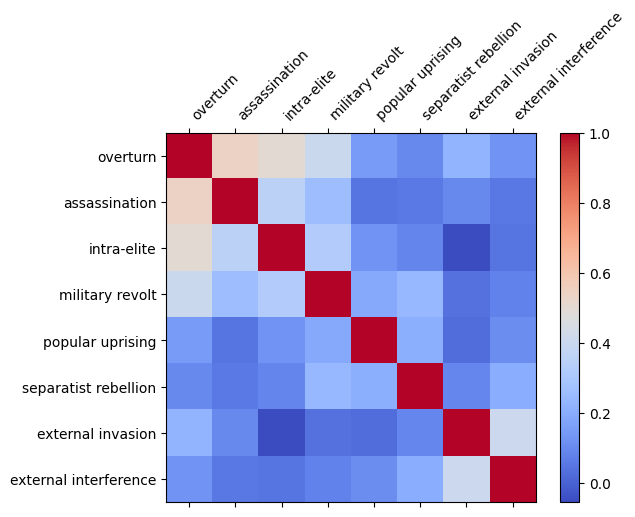

In [7]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
# columns to sum into crisis variable
crisis_keep = ['overturn', 'predecessor_assassination', 'intra_elite', 'military_revolt']
PT_mapping = {'PT_types':{}}
for c,col in enumerate(crisis_vars):
    if col in crisis_keep:
        PT_mapping['PT_types'][col] = 1
    dataset_PT.scv[col] = dataset_PT.raw[col]
    dataset_PT.scv_imputed[col] = dataset_PT.scv[col]

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']
dataset_PT.scv['duration'] = dataset_PT.raw['duration']
dataset_PT.scv_imputed['duration'] = dataset_PT.scv['duration']

# plot correlation matrix between crisis variables
corr = dataset_PT.scv[crisis_vars].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
labels = ['overturn','assassination','intra-elite','military revolt','popular uprising','separatist rebellion','external invasion','external interference']
ax.set_xticklabels(labels, rotation=45, ha='left')
ax.set_yticklabels(labels)
plt.colorbar(cax)
plt.show()

# Calculate Scale, Comp and Miltech

In [8]:
scale_cols = ['Pop', 'Terr', 'Cap', 'Hierarchy']
comp_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset_PT.scv_imputed['nScale'] = dataset_PT.scv[scale_cols].notna().sum(axis=1)
dataset_PT.scv_imputed['nComp'] = dataset_PT.scv[comp_cols].notna().sum(axis=1)

Compute Scale PCA which creates the variable 'Scale_1' indicating the first principal component of the scale variables. <br>
The PCA is done on the full dataset (containing PT and 100y datapoints) then applied to the PT dataset. This way the PCA is trained on the widest possible dataset.<br>
The Scale_1 variable is then rescaled to be reflective of the Pop variable. This is to be interpreted as follows: a Scale_1 value of 3 indicates polities that have an average population of 1000, which correspondes to Pop = 3.

In [9]:
scale_pca_cols = ['Pop','Terr','Cap']
scale_pca = dataset_FULL.compute_PCA(cols = scale_pca_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_pca_cols))
dataset_PT.compute_PCA(cols = scale_pca_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_pca_cols), pca_func = scale_pca, contributions=True, rescale=True)
dataset_100y.compute_PCA(cols = scale_pca_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_pca_cols), pca_func = scale_pca, contributions=True, rescale=True)

# Adjust the Scale_1 column
for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
    # Fit linear model to rescale the PCA according to variable Pop
    lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
    X = lm_df[['Pop']]
    y = lm_df['Scale_1']

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Extract the coefficients
    intercept = model.intercept_
    slope = model.coef_[0]
    dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope



there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.50%
PC2: 7.43%
PC3: 3.07%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.50%
PC2: 7.43%
PC3: 3.07%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.50%
PC2: 7.43%
PC3: 3.07%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57


Same thing is done on the institutional variables

In [10]:
inst_cols = ['Government', 'Infrastructure', 'Information', 'Money', 'MSP']
inst_pca = dataset_FULL.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols))
dataset_PT.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols), pca_func = inst_pca, contributions=True, rescale=True)
# all PC1 contributions are negative, adding the minus sign to the PC1 ensures the PC1 is positively correlated with the original variables
dataset_PT.scv_imputed['Inst_1'] = -dataset_PT.scv_imputed['Inst_1']

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 59.82%
PC2: 17.62%
PC3: 10.07%
PC4: 7.84%
PC5: 4.66%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 59.82%
PC2: 17.62%
PC3: 10.07%
PC4: 7.84%
PC5: 4.66%
PC1 contributions:
Government: -0.47
Infrastructure: -0.32
Information: -0.49
Money: -0.50
MSP: -0.43


Compute COMP and MILTECH

In [11]:
for dataset in [dataset_PT, dataset_FULL, dataset_100y]:
    comp_mapping = {'Comp':{'Government': 11, 'Infrastructure': 12, 'Information':13, 'Money': 6}}
    dataset.scv_imputed['Comp'] = dataset.scv_imputed.apply(lambda row: weighted_mean(row, comp_mapping,category = 'Comp',imputation = "remove", min_vals=0.5), axis=1)
    # build warfare aggregates the warfare variables and computes Miltech and IronCav
    # dataset.build_warfare()
    dataset.scv_imputed['Miltech'] = dataset.scv['Miltech']


save imputed dataset

In [12]:
dataset_PT.save_dataset('../datasets', 'PT_dataset_imputed')
dataset_100y.save_dataset('../datasets', '100y_dataset_imputed')

Dataset saved to ../datasets\PT_dataset_imputed.xlsx
Dataset saved to ../datasets\100y_dataset_imputed.xlsx


# Plot scale and comp

C:\Users\matil\AppData\Local\Temp\ipykernel_17908\500665668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.sort_values('Crisis', inplace=True,ascending=True)


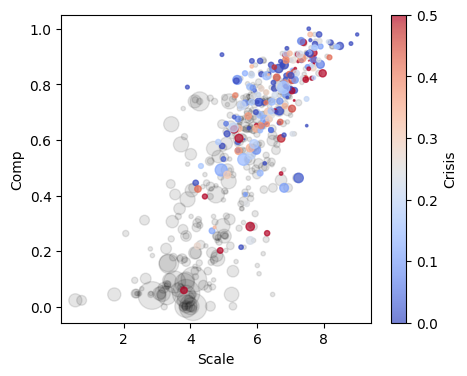

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4))

dataset_plot_100 = dataset_100y.scv_imputed.dropna(subset = ['Comp', 'Scale_1'])
polity_group_100 = dataset_100y.scv_imputed.groupby('PolityName')

mean_comp_100 = polity_group_100['Comp'].mean()
mean_scale_100 = polity_group_100['Scale_1'].mean()
num_observations_100 = polity_group_100['Year'].max() - polity_group_100['Year'].min()

scatter = plt.scatter(mean_scale_100, mean_comp_100,
                      c='black',
                      s=num_observations_100/10,
                      alpha=0.1,
                      )

dataset_plot = dataset_PT.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group['Year'].max() - polity_group['Year'].min()

v_max = mean_crisis.max()*0.5
v_min = mean_crisis.min()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = v_min,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations /10,
                      alpha=0.7,
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

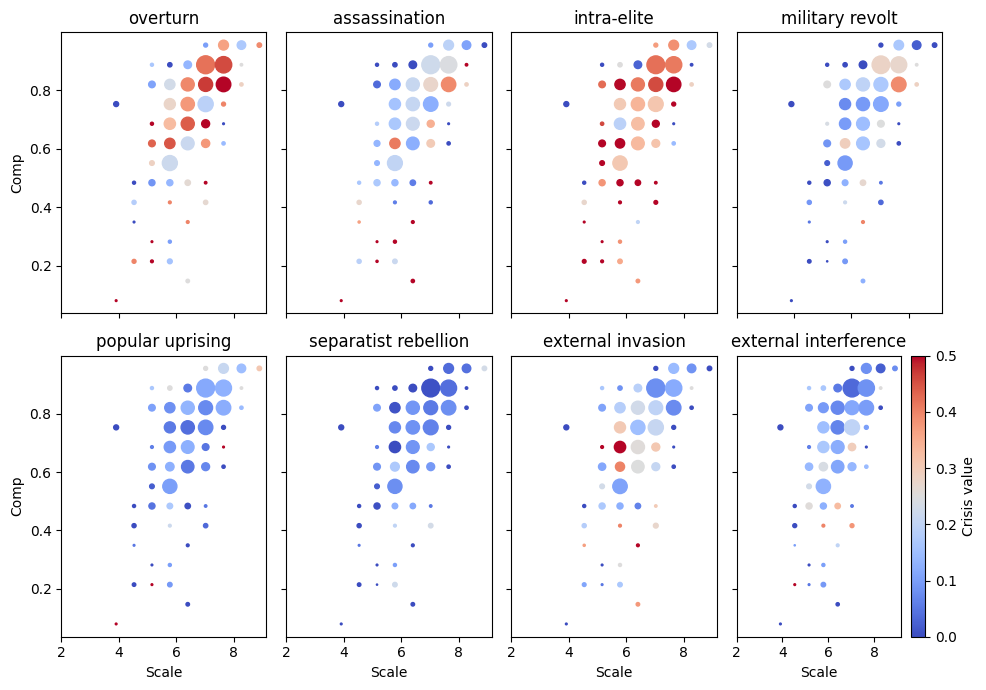

In [14]:
scv_imp = dataset_PT.scv_imputed
nbins = 15
scale = np.linspace(0, 10, nbins)
delta = scale[1] - scale[0]
comp = np.zeros(nbins)
comp_std = np.zeros(nbins)
crisis = np.zeros((len(crisis_vars), nbins))

labels = ['overturn','assassination','intra-elite','military revolt','popular uprising','separatist rebellion','external invasion','external interference']

for i in range(nbins):
    comp[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().mean()
    comp_std[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().std()
    for j, col in enumerate(crisis_vars):
        crisis[j, i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)][col].dropna().mean()

fig, axes = plt.subplots(2, 4, figsize=(10, 7))
axes = axes.flatten()
vmax = 0.5
for v in range(len(crisis_vars)):
    x_cols = ['Scale_1', 'Comp']
    y_col = crisis_vars[v]
    Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
    x = Xy[x_cols[0]].values
    y = Xy[x_cols[1]].values
    z = Xy[y_col].values

    grid_size = 15

    df = pd.DataFrame({'x': x, 'y': y, 'z': z})

    # Define the grid
    x_bins = np.linspace(0,10, grid_size + 1)
    y_bins = np.linspace(0,1, grid_size + 1)

    # Bin the data
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
    grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
    counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()
    x,y = np.meshgrid(x_bins, y_bins)

    axes[v].scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*0.8, vmax = 0.5)
    axes[v].grid(False)
    axes[v].set_title(labels[v])
    if v>=4:
        axes[v].set_xlabel('Scale')
    else:
        axes[v].set_xticklabels([])
    if (v == 0) or (v == 4):
        axes[v].set_ylabel('Comp')
    else:
        # remove y tick labels
        axes[v].set_yticklabels([])
    axes[v].set_yticks([0.2,0.4,0.6,0.8])
    axes[v].set_xticks([2,4,6,8])
# Add a colorbar to the last axis
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(0, vmax))
sm.set_array([])
fig.colorbar(sm, ax=axes[-1], orientation='vertical', label='Crisis value')
plt.tight_layout()
plt.show()

# Run linear regression

Testing Scale and Comp only

In [15]:
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]


logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)


Optimization terminated successfully.
         Current function value: 0.497932
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 2163
Model:                                 Logit   Df Residuals:                     2160
Method:                                  MLE   Df Model:                            2
Date:                       Fri, 11 Apr 2025   Pseudo R-squ.:                 0.01011
Time:                               10:17:15   Log-Likelihood:                -1077.0
converged:                              True   LL-Null:                       -1088.0
Covariance Type:                   nonrobust   LLR p-value:                 1.679e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.3999      0.081      4.932      0.0

Testing Miltech

In [16]:
regression_results = pd.DataFrame(columns = ['Crisis_type', 'Pop','Terr','Cap','Hier','Gov', 'Infrastructure', 'Information', 'Money', 'MSP','Miltech', 'Scale', 'Comp'])
for crisis in crisis_vars+['Crisis']:
    x_cols = ['Pop','Terr','Cap','Hierarchy','Government', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row = pd.DataFrame({'Crisis_type': crisis, 'Pop': p_vals['Pop'], 'Terr': p_vals['Terr'], 'Cap': p_vals['Cap'],'Hier': p_vals['Hierarchy'],'Gov':p_vals['Government'], 'Infrastructure': p_vals['Infrastructure'], 'Information': p_vals['Information'], 'Money': p_vals['Money'], 'MSP': p_vals['MSP'], 'Miltech': p_vals['Miltech'], 'Comp' : np.nan, 'Scale': np.nan}, index=[0])

    x_cols = ['Scale_1', 'Comp']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row['Scale'] = p_vals['Scale_1']
    row['Comp'] = p_vals['Comp']
    regression_results = pd.concat([regression_results, row], ignore_index=True)

Optimization terminated successfully.
         Current function value: 0.629907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.468495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.245190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282280
  

C:\Users\matil\AppData\Local\Temp\ipykernel_17908\2016048849.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 0.98, 'p-values for different crisis types and variables')

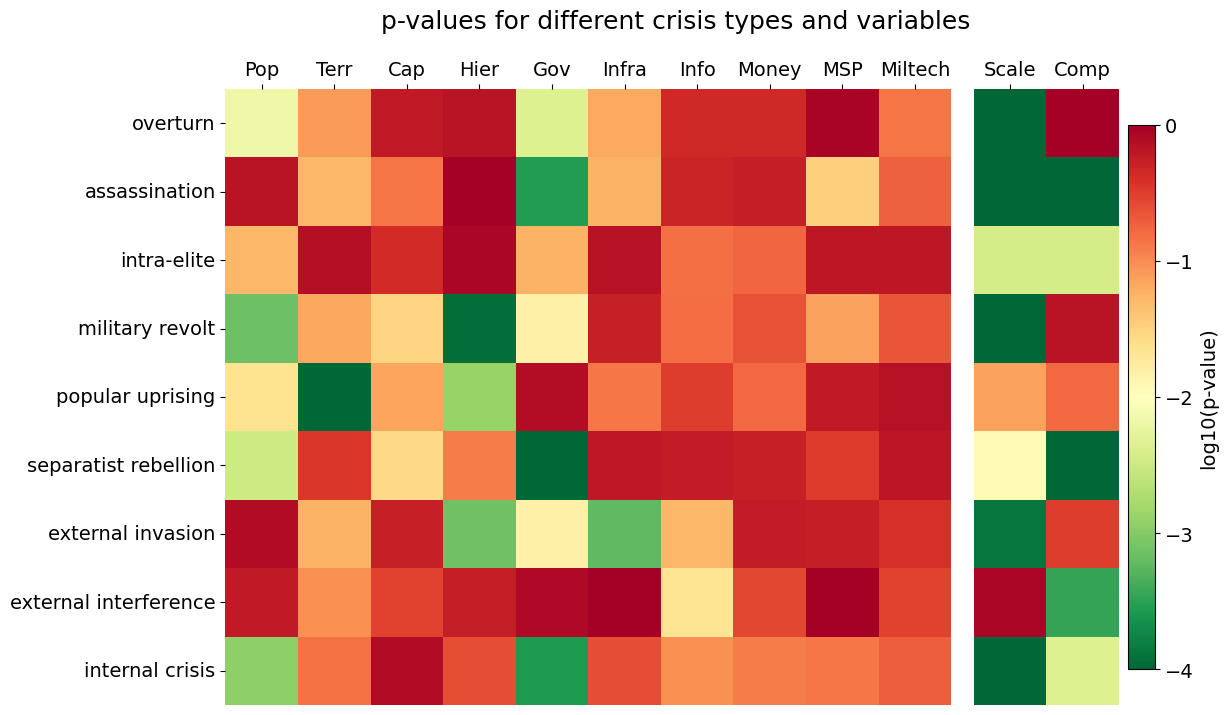

In [17]:
import matplotlib.gridspec as gridspec
import seaborn as sns

# Split data into main and side sections
main_data = regression_results[['Pop','Terr','Cap','Hier','Gov', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']].apply(np.log10)
side_data = regression_results[['Scale','Comp']].apply(np.log10)

# Create figure with custom horizontal layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Plot main heatmap
ax1 = fig.add_subplot(gs[0])
sns.heatmap(main_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax1,
            cbar=False,
            xticklabels=True)

# Plot side heatmap without y labels
ax2 = fig.add_subplot(gs[1])
sns.heatmap(side_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax2,
            cbar=False,
            yticklabels=False,
            xticklabels=True)

# Set labels only for main plot
labels = ['overturn', 'assassination', 'intra-elite', 'military revolt', 
          'popular uprising', 'separatist rebellion', 'external invasion', 
          'external interference', 'internal crisis']
labels_top = ['Pop', 'Terr', 'Cap','Hier','Gov', 'Infra', 'Info', 'Money', 'MSP', 'Miltech']
ax1.set_yticklabels(labels, rotation=0, fontsize=14)
ax1.set_xticklabels(labels_top, rotation=45, fontsize=14)

# Move x-axis labels to top for both plots
ax1.xaxis.set_ticks_position('top')
ax2.xaxis.set_ticks_position('top')
ax2.set_xticklabels(['Scale', 'Comp'], rotation=45, fontsize=14)

# Rotate x-axis labels for better readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')

# Create colorbar for the main heatmap
cbar = fig.colorbar(ax1.collections[0], ax=ax2, orientation='vertical')
cbar.set_label('log10(p-value)', fontsize=14)
cbar.set_ticks([-4, -3, -2, -1, 0])
# change font size of cbar and cbar labels
cbar.ax.tick_params(labelsize=14)


plt.tight_layout()
plt.suptitle('p-values for different crisis types and variables', fontsize=18)

testing religion

In [18]:
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp','religion_family']
y_col = 'predecessor_assassination'
Xy = dataset_PT.scv_imputed
Xy.loc[~Xy.religion_family.isin(['Christianity','Zoroastrianism']),'religion_family'] = 'Other'
Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
Xy = pd.get_dummies(Xy, columns=['religion_family'], drop_first=False)
Xy.drop(columns=['religion_family_Other'], inplace=True)

Xy['intercept'] = 1
X = Xy.drop(columns=[y_col])
y = Xy[y_col]

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())



Optimization terminated successfully.
         Current function value: 0.485642
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 2163
Model:                                 Logit   Df Residuals:                     2158
Method:                                  MLE   Df Model:                            4
Date:                       Fri, 11 Apr 2025   Pseudo R-squ.:                 0.03454
Time:                               10:17:16   Log-Likelihood:                -1050.4
converged:                              True   LL-Null:                       -1088.0
Covariance Type:                   nonrobust   LLR p-value:                 1.845e-15
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Scale_1     

Different kind of Scale and Comp plot

# Causes of polity collapse

Using the polity-preceeding-entities dataset show how the different types of succession sit on the Scale-Comp plot.

In [19]:
pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
polity_df = download_data("https://seshat-db.com/api/core/polities/")

Downloaded 450 rows
Downloaded 862 rows


In [20]:
pred_df['next_polity'] = pred_df.preceding_entity.apply(lambda x: polity_df.loc[polity_df.long_name == x].new_name.values[0] if x in polity_df.long_name.values else np.nan)
pred_df = pred_df.dropna(subset=['next_polity'])
dataset_100y.scv_imputed['polityEnd'] = dataset_100y.scv_imputed.PolityName.apply(lambda x: pred_df.loc[pred_df.next_polity == x].relationship_to_preceding_entity.values[0] if x in pred_df.next_polity.values else np.nan)

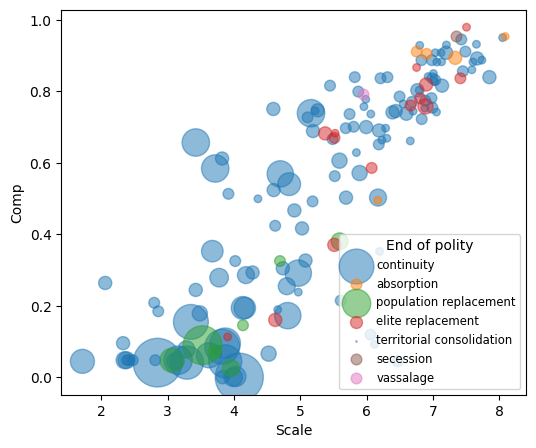

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))
for rel in pred_df.relationship_to_preceding_entity.unique():
    if pd.isna(rel) or rel == 'unknown':
        continue
    dataset_plot = dataset_100y.scv_imputed
    dataset_plot = dataset_plot.loc[dataset_plot.polityEnd == rel].dropna(subset = ['Comp', 'Scale_1'])
    polity_group = dataset_plot.groupby('PolityName')
    
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    num_observations = polity_group.size()

    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        label = rel,
                        s=num_observations * 30,
                        alpha=0.5,
                        )



# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')

plt.legend(loc='lower right', fontsize='small', title='End of polity')

plt.show()

# Threads

Constuct threads of polities using the preceeding entitites dataset and plot their trajectories on the Scale-Comp plot.

In [22]:
pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
polity_df = download_data('https://seshat-db.com/api/core/polities')

Downloaded 450 rows
Downloaded 862 rows


In [23]:
pred_df.loc[pred_df.polity_new_name == 'ug_buganda_k_2', 'preceding_entity'] = 'ug_buganda_k_1'
pred_df.loc[pred_df.polity_new_name == 'gb_british_emp_1', 'preceding_entity'] = 'gb_england_tudor_and_early_stuart'
pred_df.loc[pred_df.polity_new_name == 'us_hawaii_k', 'preceding_entity'] = 'Hawaii III'
pred_df.loc[pred_df.polity_new_name == 'nkore_k_1', 'preceding_entity'] = 'Cwezi Dynasty'
pred_df.loc[pred_df.polity_new_name == 'ye_qasimid_dyn', 'preceding_entity'] = 'Ottoman Empire II'
pred_df.loc[pred_df.polity_new_name == 'de_hohenzollern_3', 'preceding_entity'] = 'Brandenburg-Prussia'


In [24]:

pred_df_remove = pred_df.copy()
pred_df_remove = pred_df_remove.sort_values('polity_start_year', ascending = False)
pred_df_remove.reset_index(drop=True, inplace=True)
threads = []

while len(pred_df_remove) > 0:
    new_thread = []
    polity = pred_df_remove.iloc[0]
    while True:
        new_thread.append(polity.polity_new_name)
        if pd.isna(polity.preceding_entity):
            mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pd.isna(pred_df_remove.preceding_entity))
            pred_df_remove = pred_df_remove.loc[~mask]
            pred_df_remove.reset_index(drop=True, inplace=True)
            break
        pol_name = polity_df.loc[polity_df.long_name == polity.preceding_entity, 'new_name']
        if len(pol_name) == 0:
            # look for slight variations in the name
            # look for times where the polity database name includes the name of the succeeding entity
            pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: polity.preceding_entity.lower() in x.lower() if pd.notna(x) else x), 'new_name']
            # look for times where the succeeding entity includes a name of the polity database name
            if len(pol_name) == 0:
                pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: x.lower() in polity.preceding_entity.lower() if pd.notna(x) else x), 'new_name']
            # if still no match is found, remove the first row and break the loop
            if len(pol_name) == 0:
                mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
                pred_df_remove = pred_df_remove.loc[~mask]
                pred_df_remove.reset_index(drop=True, inplace=True)
                break
        if len(pol_name)>1:
            print(pol_name)
            
        pol_name = pol_name.iloc[0]
        print(pol_name)
        mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
        pred_df_remove = pred_df_remove.loc[~mask]
        pred_df_remove.reset_index(drop=True, inplace=True)
        polity = pred_df_remove[pred_df_remove.polity_new_name == pol_name]
        if len(polity) == 0:
            # polity proceeding entity exists in Seshat polity database but not in the preceding entities database
            new_thread.append(pol_name)
            break
        polity = polity.iloc[0]

    if len(pred_df_remove) < 2:
        break

    if len(new_thread) > 2:
        threads.append(new_thread[::-1])

cn_hmong_1
cn_qing_dyn_1
cn_ming_dyn
cn_yuan_dyn
mn_mongol_emp
mn_mongol_early
pg_orokaiva_pre_colonial
de_hohenzollern_2
de_hohenzollern_1
us_antebellum
gb_british_emp_1
ec_shuar_1
us_hawaii_3
us_hawaii_2
us_hawaii_1
ni_kwararafa
cn_qing_dyn_1
es_leon_k
th_ayutthaya
th_ayutthaya
us_hawaii_3
so_ajuran_sultanate
0    ug_nkore_k_2
0    ug_nkore_k_1
Name: new_name, dtype: object
ug_nkore_k_2
es_spanish_emp_1
es_castile_crown
ni_allada_k
ml_segou_k
in_mughal_emp
uz_timurid_emp
gh_akan
0    ug_buganda_k_2
0    ug_buganda_k_1
Name: new_name, dtype: object
ug_buganda_k_2
tr_ottoman_emp_2
tr_ottoman_emp_1
tr_ottoman_emirate
in_thanjavur_nayaks
in_vijayanagara_emp
in_delhi_sultanate
ni_allada_k
fr_bourbon_k_1
fr_valois_k_2
fr_valois_k_1
fr_capetian_k_2
fr_capetian_k_1
fr_carolingian_emp_2
fr_carolingian_emp_1
fr_merovingian_emp_3
fr_merovingian_emp_2
fr_merovingian_emp_1
0    in_bahmani_sultanate
0                  om_azd
0          uz_samanid_emp
Name: new_name, dtype: object
in_bahmani_sultan

In [25]:
# remove duplicate threads
all_threads = []
for thread in threads:
    if thread not in all_threads:
        all_threads.append(thread)
threads = all_threads


['mn_mongol_early', 'mn_mongol_emp', 'cn_yuan_dyn', 'cn_ming_dyn', 'cn_qing_dyn_1', 'cn_hmong_1', 'cn_hmong_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


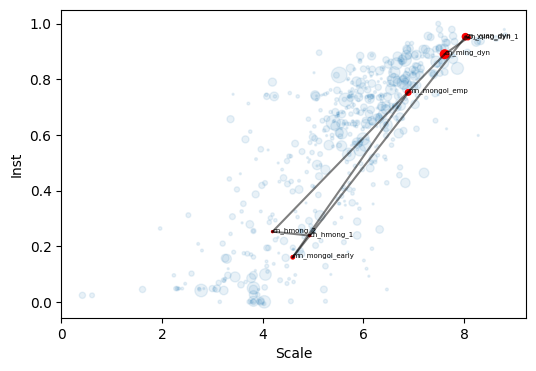

['fr_merovingian_emp_1', 'fr_merovingian_emp_2', 'fr_merovingian_emp_3', 'fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


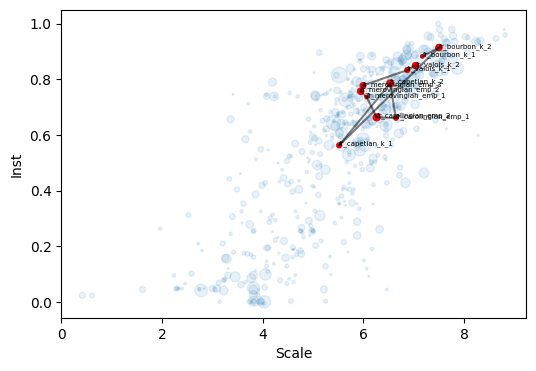

['kh_funan_1', 'kh_funan_2', 'kh_chenla', 'kh_angkor_1', 'kh_angkor_2', 'kh_angkor_3', 'kh_khmer_k']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


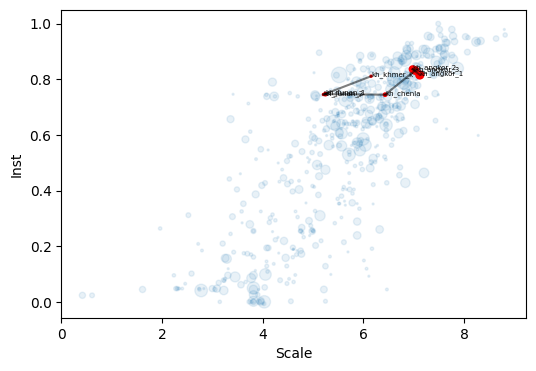

['sy_umayyad_cal', 'iq_abbasid_cal_1', 'eg_ayyubid_sultanate', 'eg_mamluk_sultanate_1', 'eg_mamluk_sultanate_2', 'eg_mamluk_sultanate_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


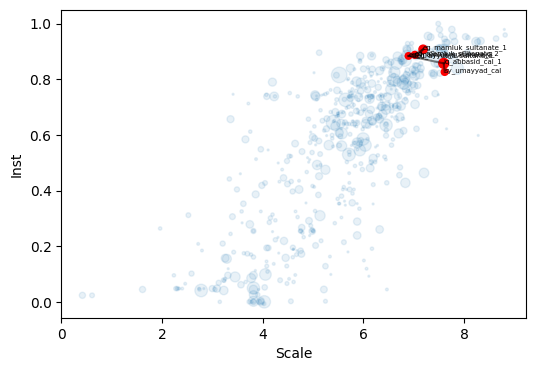

['in_kalabhra_dyn', 'in_pallava_emp_2', 'in_kadamba_emp', 'in_badami_chalukya_emp', 'in_rashtrakuta_emp', 'in_kalyani_chalukya_emp', 'in_hoysala_k']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


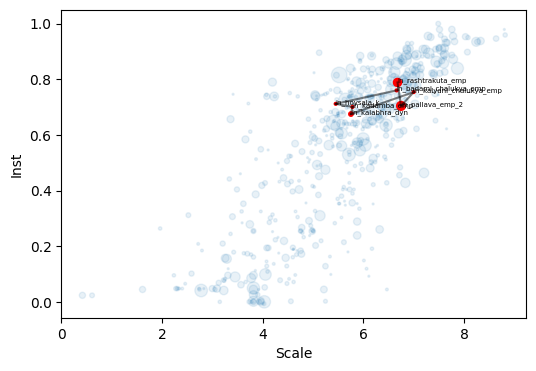

C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


['gr_macedonian_emp', 'eg_ptolemaic_k_1', 'eg_ptolemaic_k_2', 'it_roman_principate', 'tr_roman_dominate', 'tr_east_roman_emp', 'tr_byzantine_emp_1', 'tr_byzantine_emp_2', 'tr_byzantine_emp_3', 'tr_rum_sultanate']


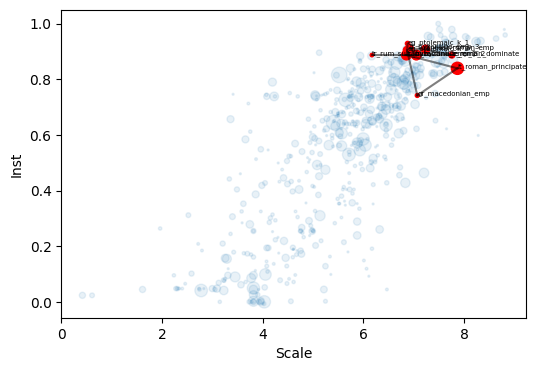

['us_woodland_1', 'us_woodland_2', 'us_woodland_3', 'us_woodland_4', 'us_woodland_5', 'us_emergent_mississippian_1', 'us_emergent_mississippian_2', 'us_cahokia_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


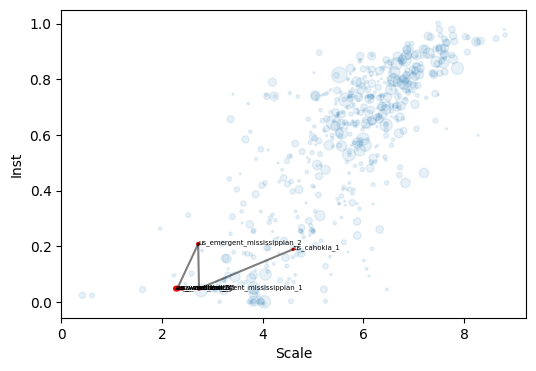

['cn_sui_dyn', 'cn_tang_dyn_1', 'mn_turk_khaganate_2', 'mn_uygur_khaganate', 'mn_khitan_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


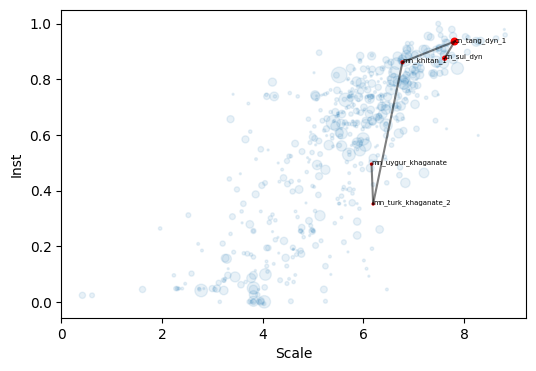

C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


['jp_jomon_1', 'jp_jomon_2', 'jp_jomon_3', 'jp_jomon_4', 'jp_jomon_5', 'jp_jomon_6', 'jp_yayoi', 'jp_kofun']


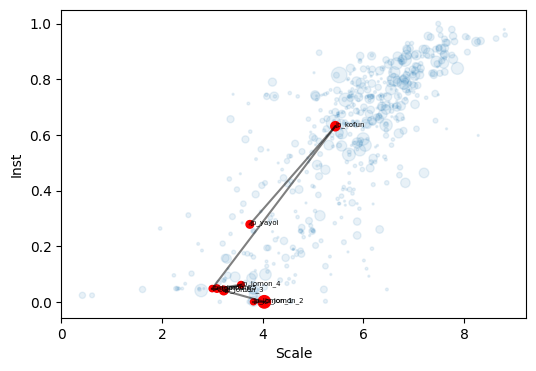

['it_latium_ca', 'it_latium_ba', 'it_latium_ia', 'it_roman_k', 'it_roman_rep_1', 'it_roman_rep_2', 'it_roman_rep_3']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


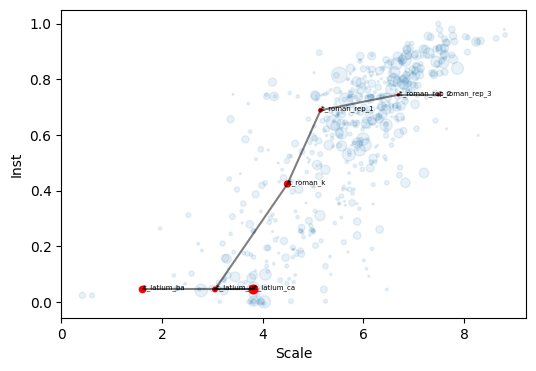

['fr_beaker_eba', 'fr_atlantic_complex', 'fr_hallstatt_a_b1', 'fr_hallstatt_b2_3', 'fr_hallstatt_c', 'fr_hallstatt_d', 'fr_la_tene_a_b1', 'fr_la_tene_b2_c1', 'fr_la_tene_c2_d']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


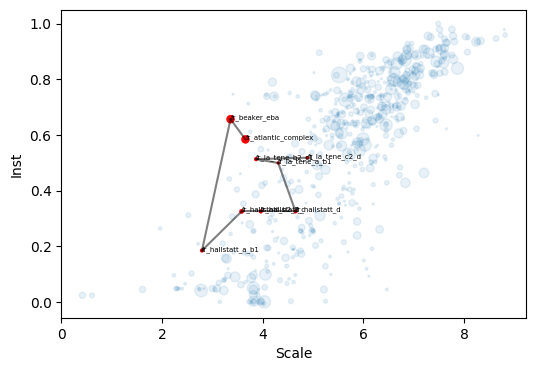

['eg_naqada_3', 'eg_dynasty_1', 'eg_dynasty_2', 'eg_old_k_1', 'eg_old_k_2', 'eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1', 'eg_new_k_2', 'eg_thebes_libyan', 'eg_kushite']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


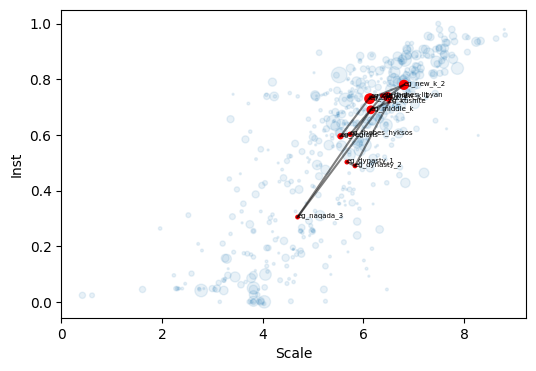

['tj_sarasm', 'kz_andronovo', 'uz_koktepe_1', 'uz_khwarasm_1', 'uz_koktepe_2']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


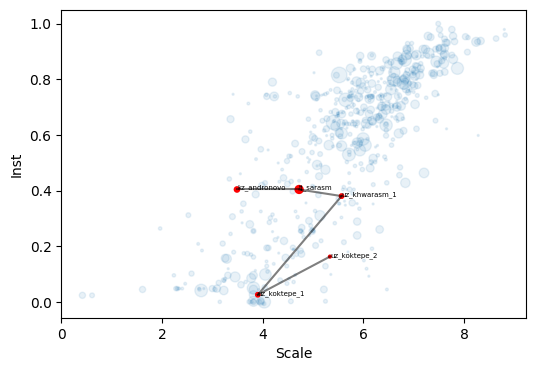

['cn_peiligang', 'cn_yangshao', 'cn_longshan', 'cn_erlitou', 'cn_erligang', 'cn_late_shang_dyn', 'cn_western_zhou_dyn', 'cn_jin_spring_and_autumn']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


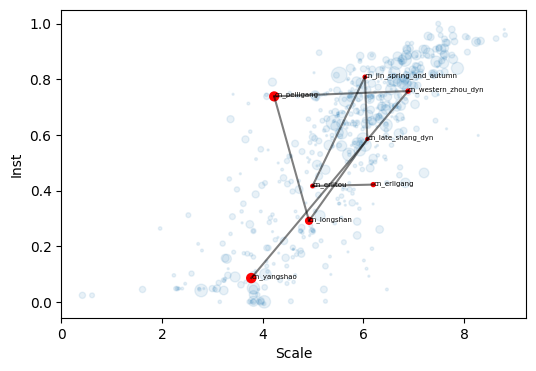

['tr_konya_lba', 'tr_hatti_old_k', 'tr_konya_lba', 'tr_hatti_new_k', 'tr_neo_hittite_k', 'tr_tabal_k', 'tr_phrygian_k']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


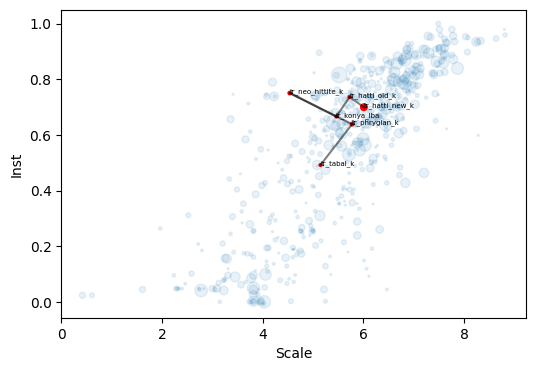

C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)


['pk_kachi_ca', 'pk_kachi_pre_urban', 'pk_kachi_urban_1', 'pk_kachi_urban_2', 'pk_kachi_post_urban', 'pk_kachi_proto_historic']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


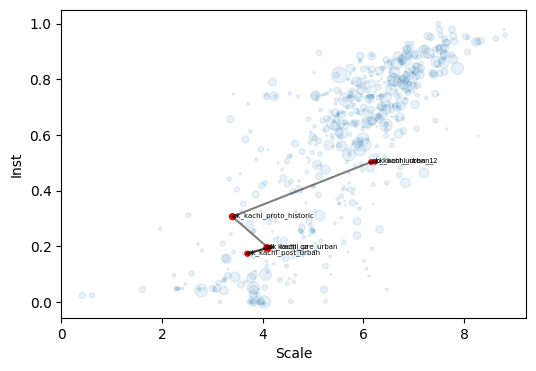

['ir_susiana_pre_ceramic', 'ir_susiana_formative', 'ir_susiana_archaic', 'ir_susiana_a', 'ir_susiana_b', 'ir_susiana_ubaid_1', 'ir_susiana_ubaid_2', 'ir_susa_1', 'ir_susa_2', 'ir_susa_3', 'ir_elam_1']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


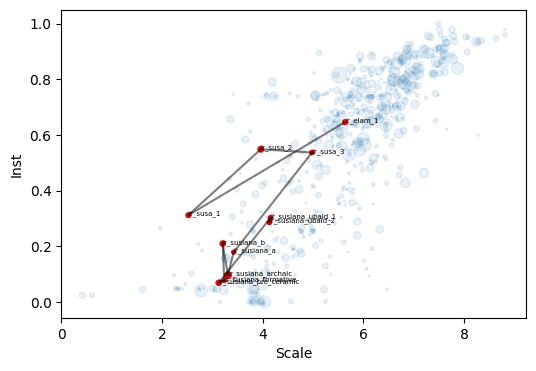

['tr_konya_enl', 'tr_konya_mnl', 'tr_konya_lnl', 'tr_konya_eca', 'tr_konya_lca', 'tr_konya_eba']


C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_17908\1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


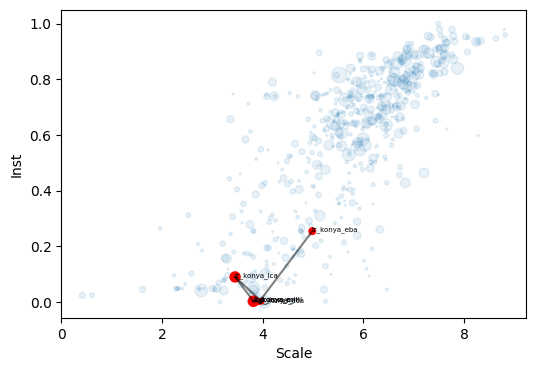

In [26]:
NGAs = dataset_FULL.scv_imputed['NGA'].unique()

for thread in threads:
    if len(thread) < 5:
        continue
    print(thread)

    dataset_plot = dataset_FULL.scv_imputed
    # dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
    polity_group = dataset_FULL.scv_imputed.groupby('PolityName')
    fig, ax = plt.subplots(figsize=(6, 4))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    v_max = mean_crisis.max()*0.6
    # add label with polity names on each bubble
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        # c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=0.1,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    thread_df = dataset_FULL.scv_imputed.loc[dataset_FULL.scv_imputed.PolityName.isin(thread)]
    thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
    polity_group = thread_df.groupby('PolityName')
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    if pd.isna(mean_crisis).all() or pd.isna(mean_inst_1).all() or pd.isna(mean_scale_1).all():
        continue

    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.plot([mean_scale_1[i-1], mean_scale_1[i]], [mean_inst_1[i-1], mean_inst_1[i]], 'k-', alpha=0.5)
        # plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.04, head_length=0.15, fc='k', ec='k', length_includes_head = True, alpha = 0.5)
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        c='r',
                        # cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=1.0,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    # Add a color bar
    # plt.colorbar(scatter, label='Crisis')

    # add label with polity names on each bubble
    for i, txt in enumerate(mean_scale_1.index):
        plt.annotate(txt, (mean_scale_1[i], mean_inst_1[i]), fontsize=5)

    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    # plt.title(nga)
    plt.show()